# Training a neural network on MNIST with Keras

This simple example demonstrates how to plug TensorFlow Datasets (TFDS) into a Keras model.


Copyright 2020 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/datasets/keras_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/datasets/blob/master/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/datasets/docs/keras_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical

2022-09-02 15:42:24.838301: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-02 15:42:24.838433: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tim/Dokumente/Projects/jupyterLab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Create your input pipeline

Start by building an efficient input pipeline using advices from:
* The [Performance tips](https://www.tensorflow.org/datasets/performances) guide
* The [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance#optimize_performance) guide


### Load a dataset

Load the MNIST dataset with the following arguments:

* `shuffle_files=True`: The MNIST data is only stored in a single file, but for larger datasets with multiple files on disk, it's good practice to shuffle them when training.
* `as_supervised=True`: Returns a tuple `(img, label)` instead of a dictionary `{'image': img, 'label': label}`.

In [2]:
#(ds_train, ds_test), ds_info = tfds.load(
#    'emnist',
#    split=['train', 'test'],
#    shuffle_files=True,
#    as_supervised=True,
#    with_info=True,
#)
charList = ['0','1','2','3','4','5','6','7','8','9',
'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

base_labeldImages = []

with open('archive/emnist-balanced-train.csv', 'r') as fp:
    lines = fp.read().splitlines()
    for line in lines:
        base_labeldImages.append(line.split(','))
        


In [3]:
#Shuffle data

np.random.shuffle(base_labeldImages)

In [4]:
base_labels = []
base_images = []    

#separate labels and images
for base_labeldImage in base_labeldImages:
    base_labels.append(base_labeldImage[0])
    base_images.append(np.resize(base_labeldImage[1:], (28,28)).astype(np.float32))



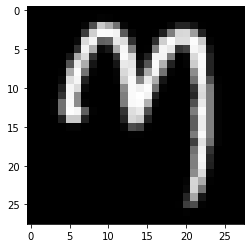

E


In [5]:
image = 3
plt.imshow(base_images[image], cmap='gray') #Bilder sind gedreht und gespiegelt
plt.show()
print(charList[int(base_labels[image])])

In [6]:
#one-hot-encoding lables

base_labelsEncoded = to_categorical(base_labels)
print(base_labelsEncoded[3])
print(base_labelsEncoded.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(112800, 47)


In [7]:
base_labelsEncoded = base_labels

In [8]:
#Split data into train, validation, test data

dataLength=len(base_labels)

train_labels = base_labelsEncoded[:int(dataLength*0.7)]
train_images = base_images[:int(dataLength*0.7)]
validation_labels = base_labelsEncoded[int(dataLength*0.7):int(dataLength*0.9)]
validation_images = base_images[int(dataLength*0.7):int(dataLength*0.9)]
test_labels = base_labelsEncoded[int(dataLength*0.9):]
test_images = base_images[int(dataLength*0.9):]

### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [9]:
def normalize_img(image):
  """Normalizes images: `uint8` -> `float32`."""
  return image / 255.

train_imagesNorm = []

for img in train_images:
    train_imagesNorm.append(normalize_img(img))
    
validation_imagesNorm = []

for img in validation_images:
    validation_imagesNorm.append(normalize_img(img))
    
test_imagesNorm = []

for img in test_images:
    test_imagesNorm.append(normalize_img(img))

In [10]:
print(type(train_imagesNorm))

for _ in train_imagesNorm:
    print(type(_))
    break

print(type(train_labels))

for _ in train_labels:
    print(type(_))
    break

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'str'>


In [11]:
arr = np.array(train_labels)

print(arr.shape)

for a in arr :
    print(a)
    break

(78960,)
38


In [12]:
arrImages = np.array(train_imagesNorm)

print(arrImages.shape)

for aImages in arrImages :
    print(aImages)
    break

(78960, 28, 28)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0

In [13]:
print(np.resize(train_imagesNorm, (len(train_imagesNorm), 28, 28, 1)).shape)


(78960, 28, 28, 1)


### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(62, "softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    #optimizer=tf.keras.optimizers.Adam(0.001),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    x = np.resize(train_imagesNorm, (len(train_imagesNorm), 28, 28, 1)),
    y = np.array(train_labels).astype(np.float32),
    epochs=30,
    validation_data=(
        np.resize(validation_imagesNorm, (len(validation_imagesNorm), 28, 28, 1)), 
        np.array(validation_labels).astype(np.float32)),
    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='tfKerasCharsEMNISTSoftmaxBalanced', save_best_only=True, monitor="val_loss"),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)]
)

2022-09-02 15:43:10.554716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-02 15:43:10.554948: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-02 15:43:10.555003: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (VirtDebian): /proc/driver/nvidia/version does not exist
2022-09-02 15:43:10.555282: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
2464/2468 [============================>.] - ETA: 0s - loss: 1.1961 - sparse_categorical_accuracy: 0.6619

2022-09-02 15:43:41.481945: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: tfKerasCharsEMNISTSoftmaxBalanced/assets
2468/2468 [==============================] - 31s 12ms/step - loss: 1.1955 - sparse_categorical_accuracy: 0.6621 - val_loss: 0.8495 - val_sparse_categorical_accuracy: 0.7519
Epoch 2/30
2468/2468 [==============================] - 30s 12ms/step - loss: 0.7646 - sparse_categorical_accuracy: 0.7696 - val_loss: 0.7272 - val_sparse_categorical_accuracy: 0.7824
Epoch 3/30
2468/2468 [==============================] - 29s 12ms/step - loss: 0.6520 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.6851 - val_sparse_categorical_accuracy: 0.7931
Epoch 4/30
2468/2468 [==============================] - 30s 12ms/step - loss: 0.6000 - sparse_categorical_accuracy: 0.8116 - val_loss: 0.6822 - val_sparse_categorical_accuracy: 0.7956
Epoch 5/30
2468/2468 [==============================] - 31s 13ms/step - loss: 0.5697 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.6723 - val_sparse_categorical_accuracy: 0.7970
Epoch 6/30
2468

In [19]:
converter = tf.lite.TFLiteConverter.from_saved_model('tfKerasCharsEMNISTSoftmaxBalanced')
tflite_model = converter.convert()

with open("tfKerasCharsEMNISTSoftmaxBalanced.tflite", "wb") as fp:
    fp.write(tflite_model)

2022-09-02 19:37:30.803392: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-09-02 19:37:30.803545: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-09-02 19:37:30.803777: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: tfKerasCharsEMNISTSoftmaxBalanced
2022-09-02 19:37:30.810586: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-09-02 19:37:30.810628: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: tfKerasCharsEMNISTSoftmaxBalanced
2022-09-02 19:37:30.827475: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-09-02 19:37:30.946210: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: tfKerasCharsEMNISTSoftmaxBalanced
2022-09-02 19:37:30.999490: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load fo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 62)                7998      
                                                                 
Total params: 108,478
Trainable params: 108,478
Non-trainable params: 0
_________________________________________________________________
Ergebnis Shape (1, 62)
Zeichen unmapped 38 Zeichen mapped c Ergebnis 0.81038094


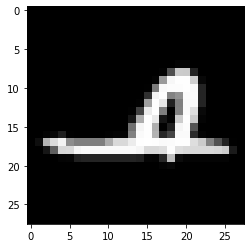

Ergebnis Shape (1, 62)
Zeichen unmapped 40 Zeichen mapped e Ergebnis 0.5158425


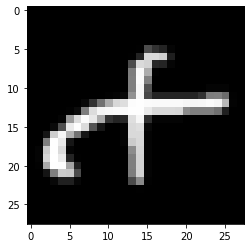

Ergebnis Shape (1, 62)
Zeichen unmapped 3 Zeichen mapped 3 Ergebnis 0.9997142


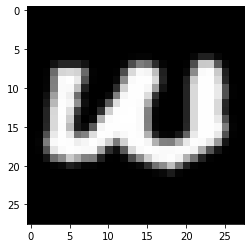

Ergebnis Shape (1, 62)
Zeichen unmapped 14 Zeichen mapped E Ergebnis 0.77646893


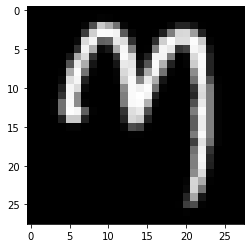

Ergebnis Shape (1, 62)
Zeichen unmapped 9 Zeichen mapped 9 Ergebnis 0.46727777


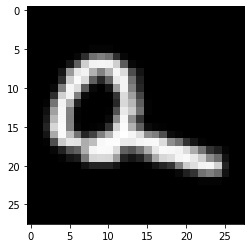

Ergebnis Shape (1, 62)
Zeichen unmapped 37 Zeichen mapped b Ergebnis 0.87404543


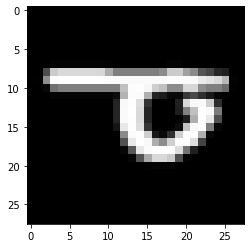

Ergebnis Shape (1, 62)
Zeichen unmapped 32 Zeichen mapped W Ergebnis 0.99507517


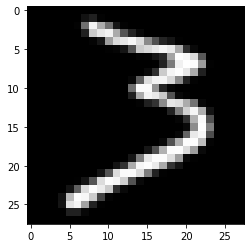

Ergebnis Shape (1, 62)
Zeichen unmapped 32 Zeichen mapped W Ergebnis 0.99998045


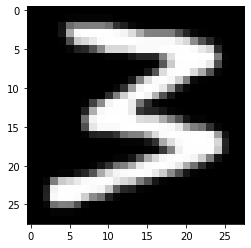

Ergebnis Shape (1, 62)
Zeichen unmapped 31 Zeichen mapped V Ergebnis 0.9951298


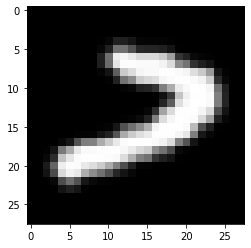

Ergebnis Shape (1, 62)
Zeichen unmapped 26 Zeichen mapped Q Ergebnis 0.93745345


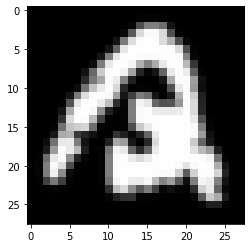

Ergebnis Shape (1, 62)
Zeichen unmapped 38 Zeichen mapped c Ergebnis 0.99810934


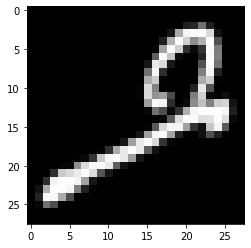

In [16]:
import numpy as np
import tensorflow as tf

charList = ['0','1','2','3','4','5','6','7','8','9',
'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

model = tf.keras.models.load_model('tfKerasCharsEMNISTSoftmaxBalanced')
model.summary()

i = 0

for test in train_imagesNorm:
    ele = np.resize(test,(1,28,28,1))
    erg = model.predict(ele)
    print("Ergebnis Shape", erg.shape)
    print("Zeichen unmapped", np.argmax(erg), "Zeichen mapped", charList[np.argmax(erg)], "Ergebnis", erg[0][np.argmax(erg)])
    plt.imshow(ele[0], cmap='gray') #Bilder sind gedreht und gespiegelt
    plt.show()
    i += 1
    if i > 10:
        break
    

In [17]:
import numpy as np
import tensorflow as tf

model = tf.keras.models.load_model('tfKerasCharsEMNISTSoftmaxBalanced')
model.summary()

data = np.random.randint(0, 255, (1, 28, 28))/255

print(data.shape)
#print(data[1][1])

erg = model.predict(data)
#print(np.argmax(erg))
print(erg)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 62)                7998      
                                                                 
Total params: 108,478
Trainable params: 108,478
Non-trainable params: 0
_________________________________________________________________
(1, 28, 28)
[[2.3752152e-28 0.0000000e+00 5.6849551e-26 0.0000000e+00 0.0000000e+00
  7.5360146e-29 0.0000000e+00 8.4761277e-31 8.5522874e-32 0.0000000e+00
  3.3028429e-23 2.4478348e-08 7.9497237e-22 5.2501094e-03 5.8237984e-23
  7.9060690e-18 3.0246682e-23 3.0171406e-17 1.8450321e-38 1.9052502e-14
  2.6168266e-1

In [20]:
import numpy as np

interpreter = tf.lite.Interpreter(model_path="tfKerasCharsEMNISTSoftmaxBalanced.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], data.astype(np.float32))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[2.37514396e-28 0.00000000e+00 5.68426359e-26 0.00000000e+00
  0.00000000e+00 7.53509919e-29 0.00000000e+00 8.47483843e-31
  8.55150746e-32 0.00000000e+00 3.30264254e-23 2.44746232e-08
  7.94948438e-22 5.24963159e-03 5.82362301e-23 7.90559011e-18
  3.02485369e-23 3.01677335e-17 2.33826603e-38 1.90507688e-14
  2.61650808e-13 1.09133224e-25 1.13735274e-20 5.82147188e-22
  4.82402495e-26 5.98007122e-20 9.94588375e-01 3.47856910e-10
  0.00000000e+00 2.04908677e-22 1.11148823e-22 7.20099621e-28
  2.87703756e-07 1.12577897e-37 8.25637837e-24 1.61760341e-04
  9.35480798e-32 0.00000000e+00 2.33826603e-38 0.00000000e+00
  8.01009474e-21 1.06466501e-19 4.67653207e-38 5.62875408e-30
  2.60729468e-26 0.00000000e+00 8.06837258e-26 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
